# 非线性激活函数量化——查表法

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [43]:
# 量化比特数
bit_nums = 8
# lut表大小
lut_size = 32

q_min = 0
q_max = 2 ** bit_nums - 1

in_scale = 20 / (2 ** bit_nums - 1)
in_zp = np.clip(np.round(q_max - 10 / in_scale), q_min, q_max)
out_scale = 1 / (2 ** bit_nums - 1)
out_zp = np.clip(np.round(q_max - 1 / out_scale), q_min, q_max)

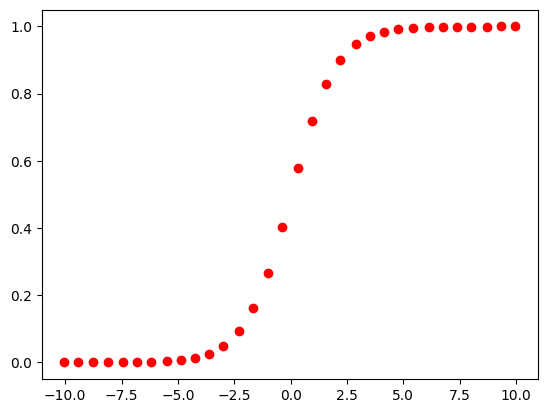

In [44]:
# 生成 lut 表的采样点
q_x = np.round(np.linspace(0, 2 ** bit_nums - 1, lut_size))
# 反量化到 [-10, 10]
x = (q_x - in_zp) * in_scale
# 计算 sigmoid 函数的值
y = sigmoid(x)
# 函数值量化到 [0, 255]
q_y = np.clip(np.round(y / out_scale) + out_zp, q_min, q_max)
plt.plot(x, y, 'ro')

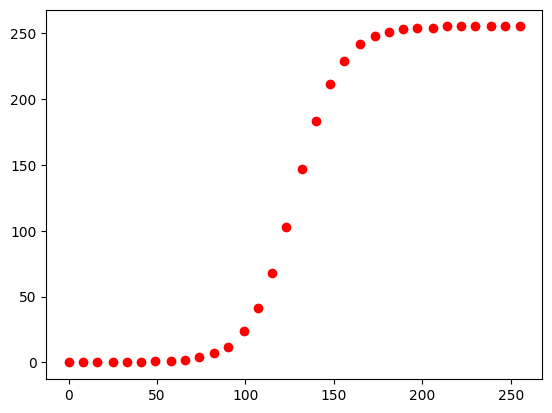

In [45]:
plt.plot(q_x, q_y, 'ro')

## 推理阶段

In [65]:
x=2
q_x1=np.round(x/in_scale)+in_zp
y=np.interp(q_x1, q_x, q_y)
print(y)
y=(y-out_zp)*out_scale
print(y)

224.5
0.8784313725490196


In [47]:
print(sigmoid(2))

0.8807970779778823


## 非线性函数电路

In [48]:
from concrete import fhe
import numpy as np

In [58]:
@fhe.compiler({"q_x":"Encrypted"})
def q_sigmoid(q_x):
    out=(1/(1+np.exp(-q_x))*100000).astype(np.int64)
    return out

inputset = np.array([0,256])
circuit=q_sigmoid.compile(inputset)

In [71]:
q_x1=np.round(2/in_scale)+in_zp
q_x1=q_x1.astype(np.int64)
result=circuit.encrypt_run_decrypt(q_x1)/100000
# 函数值量化到 [0, 255]
q_result = np.clip(np.round(result / out_scale) + out_zp, q_min, q_max)
result=(q_result-out_zp)*out_scale
print(result)

0.10196078431372549
